# Building your own dataset - Reddit Scrape
In this notebook I will walk you through building your own dataset to create unique one of a kind projects. 

Although this example uses reddit you can follow a similar path to build many different types of datasets.

We will also load in and do some visualations of our data set after we build it.

# Install libraries

We are going to use two libraries to scrape data from reddit. praw will allow us to work with reddit API and psaw will wrap around it to handle multiple requests.

We need psaw because praw will only return 1000 results and we need way more data in our projects!

In [1]:
%%capture
!pip install praw
!pip install psaw

# Import Libraries



In [2]:
import csv
from datetime import datetime
import os
import pandas as pd
import praw
from psaw import PushshiftAPI

# Create a Reddit developer account
If you want to scrape your own data you will need to create a reddit developer account. 

I have the data in the notebook so feel free to skip and use the data already provided.

- Signup for a reddit account.
- Select the "Are you a developer? Create an app button"
- Give you program a name and a redirect URL ( http://localhost ).
- On the final screen note your client id and secret.

| Create Account | Access Developer | Name | ID and secret |
| --- | --- | --- | --- |
| <img src="https://i.imgur.com/l5tWhOW.png" title="source: imgur.com" width="200" height="200" /> | <img src="https://i.imgur.com/Ir7Nqx6.png" title="source: imgur.com" width="200" height="200" /> | <img src="https://i.imgur.com/1hoKGvH.png" title="source: imgur.com" width="200" height="200" /> | <img src="https://i.imgur.com/JmH5vBn.png" title="source: imgur.com" width="200" height="200" /> |

Enter the detail below. **Warning** you must change my credentials they will not work. 

In [3]:
reddit = praw.Reddit(
    client_id="CE-Your-Client-id-w",
    client_secret="U-Your-Client-secret-w",
    user_agent="<ShowerThoughts-DataDive>"
)

# Setting up our data query.

Setup a start and end data for our query so we can gather a year of data. 
We select the subreddit we want to query which is ShowerThoughts. 
This is a subreddit where people post short funny thoughts you might have as your bain wanders.


<blockquote>You aren't paid according to how hard you work, you are paid according to how hard you are to replace</blockquote>

Finally we create a generator that we will use to query our data.

In [4]:
start_epoch=int(datetime(2020, 1, 1).timestamp())
end_epoch=int(datetime(2021, 1, 1).timestamp())
api = PushshiftAPI(reddit)
gen = api.search_submissions(after=start_epoch, before=end_epoch,
                            subreddit='Showerthoughts')

# Gathering the data

A little setup here first by setting where our data will be stored and the file name. I choose to break up my data as I query it by month so if something fails in the middle we only have to replace  that month.

In [5]:
data_folder = "./data_files/"
file_name = "12-2020"

### Finally lets actually write our data.

$\color{red}{\text{Warning}}$ - This process will take a long time to complete if you want to follow along feel free to use data I have already provided in the notebook.

Submissions - We are getting back a submission from our query and pulling data attributes off of it.
- ID
- Title
- Author
- URL
- View_count
- Score
- created_utc ( We will break this down into month day and hour)

In [6]:
cvsWriter = csv.writer(open(f"{data_folder}{file_name}.csv", 'a', encoding="UTF-8"))
count = 0
for submission in gen:
    count += 1
    dt_object = datetime.fromtimestamp(submission.created_utc)
    if file_name != f"{dt_object.month}-{dt_object.year}":
        file_name = f"{dt_object.month}-{dt_object.year}"
        print(f"Switching data files {file_name}")
        cvsWriter = csv.writer(open(f"{data_folder}{file_name}.csv", 'a', encoding="UTF-8"))
    cvsWriter.writerow([submission.id, submission.title, submission.author, submission.url, submission.view_count, submission.score, dt_object.month, dt_object.day, dt_object.year, dt_object.hour])
f.close()

# Loading Data

Now that we have our data created lets load it and take a quick look at what we got!

- Going to take any csv file in our data_folder and load it into our data_holder list.
- We didn't add columns to our data so lets make every row a dictionary with only the data we are interested in using. (id, title, score, month, hour)
- Note the data is stored in the same directory as the notebook inside of a folder called data_files


In [7]:
data_holder = []
for root,dirs,files in os.walk(data_folder):
    for file in files:
       if file.endswith(".csv"):
            with open(data_folder + file) as csv_file:
                csv_reader = csv.reader(csv_file, delimiter=',')
                line_count = 0
                for row in csv_reader:
                    try:
                        data_holder.append({"id":row[0], "title":row[1], "score":int(row[5]),"month":int(row[6]), "hour":int(row[9])})
                    except:
                        print(row)
                    line_count += 1
                print(f'Processed {line_count} lines from {file}')

Processed 88757 lines from 6-2020.csv
Processed 71227 lines from 9-2020.csv
Processed 29733 lines from 1-2020.csv
Processed 57939 lines from 12-2020.csv
Processed 81881 lines from 8-2020.csv
Processed 87284 lines from 7-2020.csv
Processed 141507 lines from 3-2020.csv
Processed 65712 lines from 10-2020.csv
Processed 107825 lines from 4-2020.csv
Processed 58819 lines from 11-2020.csv
Processed 100791 lines from 2-2020.csv
Processed 101123 lines from 5-2020.csv


### Let's check out the total data items we have and an example of a row.

In [8]:
print(f"Total Items: {len(data_holder)}")
data_holder[0]

Total Items: 992598


{'id': 'hizcp4',
 'title': 'Land mammals (horses for example) were some of the first vehicles with automatic collision avoidance',
 'score': 6927,
 'month': 6,
 'hour': 23}

### Now let's create a function to give us some information about the data.

I am interested in the average score of a post and the average length of a post. 

Also how many posts end up with a score of 1 ( your starting score ) or 0 (lowest score possible ). 

In [9]:
def thought_stats(data):
    total_score = 0
    total_length = 0
    max_score = 1
    min_score = 1

    scored_0 = 0
    scored_1 = 0
    scored_over_1 = 0

    for thought in data:
        total_score += thought['score']
        total_length += len(thought['title'])
        if thought['score'] > max_score:
            max_score = thought['score']
        elif thought['score'] < min_score:
            min_score = thought['score']

        if thought['score'] == 0:
            scored_0 += 1
        elif thought['score'] == 1:
            scored_1 += 1
        else:
            scored_over_1 += 1
    
    print(f"Average Score: {round(total_score / len(data),2)}\nMax Score: {max_score}\nMin Score: {min_score}")
    print(f"Average Length: {round(total_length / len(data),2)}\n")
    print(f"Scored 0: {scored_0} thoughts {round(scored_0/len(data)*100,2)}%")
    print(f"Scored 1: {scored_1} thoughts {round(scored_1/len(data)*100,2)}%")
    print(f"Got an upvote! {scored_over_1} thoughts {round(scored_over_1/len(data)*100,2)}%")


### Interesting data already!
The average score is 80 but 72% have a score of 0 or 1!

In [10]:
thought_stats(data_holder)

Average Score: 80.13
Max Score: 152376
Min Score: 0
Average Length: 86.48

Scored 0: 41428 thoughts 4.17%
Scored 1: 676774 thoughts 68.18%
Got an upvote! 274396 thoughts 27.64%


### Lets covert to a pandas dataframe and plot some quick charts.

In [11]:
df = pd.DataFrame(data_holder)

In [12]:
df

,id,title,score,month,hour
0,hizcp4,Land mammals (horses for example) were some of...,6927,6,23
1,hizcjz,Beer commercials never show people enjoying th...,6,6,23
2,hizc21,"If you take the quarantine as a video game, th...",1,6,23
3,hizbtk,Most of the earth's atmosphere is below your f...,1,6,23
4,hizbfb,You can probably travel back in time along all...,1,6,23
...,...,...,...,...,...
992593,gb7iho,There are few words in the English language th...,1,5,0
992594,gb7i68,"If you can play music well enough, you get to ...",6,5,0
992595,gb7hyf,"We call 12am midnight, but when we refer to th...",1,5,0
992596,gb7hqw,Sleeping is just one really long blink,1,5,0


### We can add columns to our dataframe here I add length of post.

In [13]:
df['title_length'] = df['title'].str.len()

In [14]:
df

,id,title,score,month,hour,title_length
0,hizcp4,Land mammals (horses for example) were some of...,6927,6,23,100
1,hizcjz,Beer commercials never show people enjoying th...,6,6,23,75
2,hizc21,"If you take the quarantine as a video game, th...",1,6,23,212
3,hizbtk,Most of the earth's atmosphere is below your f...,1,6,23,50
4,hizbfb,You can probably travel back in time along all...,1,6,23,163
...,...,...,...,...,...,...
992593,gb7iho,There are few words in the English language th...,1,5,0,83
992594,gb7i68,"If you can play music well enough, you get to ...",6,5,0,106
992595,gb7hyf,"We call 12am midnight, but when we refer to th...",1,5,0,92
992596,gb7hqw,Sleeping is just one really long blink,1,5,0,38


### First I want to group by hour and see if the time of day effects the mean score.

In [15]:
df_hour = df.sort_values(by=['hour']).groupby('hour').mean()
df_hour

,score,month,title_length
hour,,,
0,72.176626,6.027556,86.210579
1,83.041806,6.055384,85.371948
2,63.701569,6.045741,85.504415
3,53.930733,6.052069,85.448733
4,48.366508,6.075108,86.438697
5,58.857265,6.151942,85.995589
6,54.408301,6.137250,86.100445
7,65.194798,6.139553,85.470088
8,72.499673,6.113298,85.766407


<AxesSubplot:xlabel='hour'>

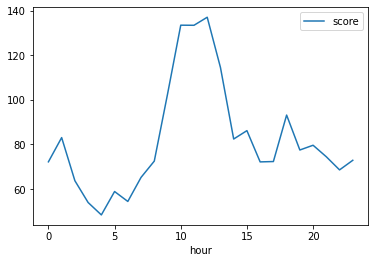

In [16]:
df_hour.plot(y='score')

### Let's do the same thing for the month.

In [17]:
df_month = df.sort_values(by=['month']).groupby('month').mean()
df_month

,score,hour,title_length
month,,,
1,84.359533,12.399993,86.972085
2,82.899078,12.122451,85.803732
3,65.765679,12.180175,88.553026
4,72.213652,12.167688,85.398831
5,81.389130,12.006754,86.362944
6,74.515757,12.048289,85.962842
7,78.285150,12.080610,87.141630
8,86.163151,12.141987,85.817723
9,88.554509,12.310332,85.719390


<AxesSubplot:xlabel='month'>

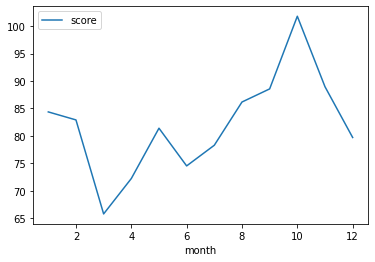

In [18]:
df_month.plot(y='score')

As you can see we have created our own dataset with some interesting insights already. I plan on using the dataset to try and predit the score of the post or create some sort of post generator! Please feel free to use this as a starting point for projects of you own!

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8cf1d36e-28b8-484e-9518-ce9939400323' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>